In [1]:
import pandas as pd
import numpy as np
import scipy
import matplotlib.pyplot as plt
from statsmodels.stats.weightstats import *
from statsmodels.stats.proportion import proportion_confint

In [2]:
ab_test = pd.read_csv("ab_browser_test.csv", sep = ",", header = 0)
ab_test.head()

,userID,browser,slot,n_clicks,n_queries,n_nonclk_queries
0,1,Browser #2,exp,23,32,19
1,3,Browser #4,exp,3,4,2
2,5,Browser #4,exp,29,35,16
3,6,Browser #4,control,12,6,0
4,7,Browser #4,exp,54,68,30


In [3]:
ab_test_exp = ab_test[ab_test["slot"] == "exp"]
ab_test_ctr = ab_test[ab_test["slot"] == "control"]

clicks_per_query_exp = map(lambda x: float(x[0])/float(x[1]), zip(ab_test_exp['n_clicks'],ab_test_exp['n_queries']))
clicks_per_query_ctr = map(lambda x: float(x[0])/float(x[1]), zip(ab_test_ctr['n_clicks'],ab_test_ctr['n_queries']))
clicks_exp_avg = reduce(lambda x, y: x + y, clicks_per_query_exp) / len(clicks_per_query_exp)
clicks_ctr_avg = reduce(lambda x, y: x + y, clicks_per_query_ctr) / len(clicks_per_query_ctr)

clicks_proportion = 100*(clicks_exp_avg)/ (clicks_ctr_avg) - 100
clicks_proportion

7.494280770883179

In [77]:
clicks_proportion = (sum(ab_test_exp['n_clicks']))*1.0/ (sum(ab_test_ctr['n_clicks']))
round((clicks_proportion - 1)*100 , 3)

1.614

In [80]:
def get_bootstrap_samples(data, n_samples):
    indices = np.random.randint(0, len(data), (n_samples, len(data))) 
    samples = data[indices]
    return samples

def stat_intervals(stat, alpha):
    boundaries = np.percentile(stat, [100 * alpha / 2., 100 * (1 - alpha / 2.)])
    return boundaries


np.random.seed(0)

clicks_exp_median = map(np.median, get_bootstrap_samples(np.asarray(ab_test_exp['n_clicks']), 500))
clicks_ctr_median = map(np.median, get_bootstrap_samples(np.asarray(ab_test_ctr['n_clicks']), 500))

delta_median_scores = map(lambda x: x[1] - x[0], zip(clicks_per_query_exp_median,
                                                     clicks_per_query_ctr_median))
print 'доверительный интервал для разницы медиан: ',  stat_intervals(delta_median_scores, 0.05)

доверительный интервал для разницы медиан:  [-1. -1.]


In [81]:
clicks_exp_mean = map(np.mean, get_bootstrap_samples(np.asarray(ab_test_exp['n_clicks']), 300))
clicks_ctr_mean = map(np.mean, get_bootstrap_samples(np.asarray(ab_test_ctr['n_clicks']), 300))

delta_mean_scores = map(lambda x: x[1] - x[0], zip(clicks_per_query_exp_mean,
                                                     clicks_per_query_ctr_mean))
print 'доверительный интервал для разницы cредних: ',  stat_intervals(delta_mean_scores, 0.05)

доверительный интервал для разницы cредних:  [-0.40319088 -0.19269246]


In [23]:
np.random.seed(0)
n_boot_samples = 500

In [24]:
n_boot_samples = get_bootstrap_samples(np.asarray(clicks_per_query_ctr), n_boot_samples)

In [25]:
control_boot_mean = np.mean(n_boot_samples, axis = 1)
control_boot_chi_squared = np.var(n_boot_samples, axis = 1)

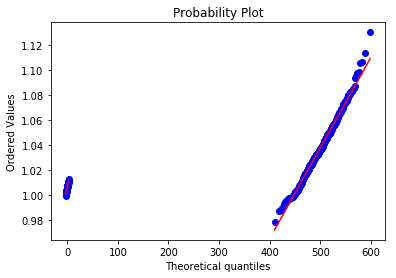

0.9971568611748132

In [38]:
stats.probplot(control_boot_mean, dist="norm", plot=plt)
plt.show()
res1, res2 = stats.probplot(control_boot_mean, dist="norm", plot=plt)
res2[2]**2

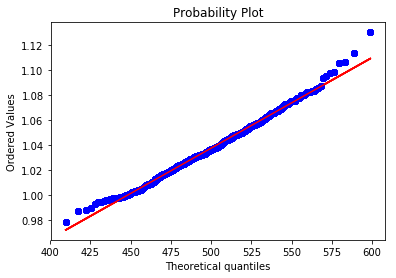

0.9931762067744013

In [37]:
scipy.stats.probplot(control_boot_chi_squared, dist="chi2", sparams=(499), plot=plt)
plt.show()
res1, res2 = scipy.stats.probplot(control_boot_chi_squared, dist="chi2", sparams=(499), plot=plt)
res2[2]**2

In [48]:
ab_test_exp_by_user = ab_test_exp.groupby(by='userID')['n_clicks'].agg(np.sum)
ab_test_ctr_by_user = ab_test_ctr.groupby(by='userID')['n_clicks'].agg(np.sum)

In [54]:
stats.mannwhitneyu(ab_test_exp_by_user, ab_test_ctr_by_user)

4.3471471887604393e-75

In [52]:
browsers = ab_test.browser.unique()

In [65]:
from statsmodels.sandbox.stats.multicomp import multipletests 

pvalues = []
for br in browsers:
    ab_test_exp_br = ab_test_exp[ab_test_exp['browser'] == br]
    ab_test_ctr_br = ab_test_ctr[ab_test_ctr['browser'] == br]
    pval = stats.mannwhitneyu(ab_test_exp_br['n_clicks'], ab_test_ctr_br['n_clicks']).pvalue
    pvalues.append(pval)
    print stats.mannwhitneyu(ab_test_exp_br['n_clicks'], ab_test_ctr_br['n_clicks']).pvalue

reject, p_corrected, a1, a2 = multipletests(pvalues, alpha = 0.05, method = 'holm')
    

0.0272438604197241
0.40760617658454984
0.0
0.03740060143010802
0.45366656388735377
0.2574055152210032


In [66]:
reject

array([False, False,  True, False, False, False])

In [70]:
percent = []
for br in browsers:
    ab_test_exp_br = ab_test_exp[ab_test_exp['browser'] == br]
    ab_test_ctr_br = ab_test_ctr[ab_test_ctr['browser'] == br]
    nonclick_proportion_ctr = float(sum(ab_test_ctr_br.n_nonclk_queries)) / float(sum(ab_test_ctr_br.n_queries))
    nonclick_proportion_exp = float(sum(ab_test_exp_br.n_nonclk_queries)) / float(sum(ab_test_ctr_br.n_queries))
    percent.append([nonclick_proportion_exp, nonclick_proportion_ctr])

percent

[[0.4353532695557883, 0.4596274717919465],
 [0.43035490223620365, 0.4697092963514274],
 [0.44163172594089956, 0.5759041136008114],
 [0.37149927484551576, 0.36299366746282086],
 [0.3767599818324456, 0.4054048474338329],
 [0.38111396346838067, 0.40593976593513353]]